### Лабораторная №2

Импортируем необходимые библиотеки

In [176]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

### Загрузим данные для обучения и для теста и глянем на столбцы

In [177]:
sample_len = 20000
df_train = pd.read_csv('train.csv')
train = df_train.sample(n=sample_len, replace=False, random_state=42)
test = pd.read_csv('test.csv')
train.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
46429,330050,Female,24,1,30.0,1,< 1 Year,No,24387.0,152.0,279,0
143349,97345,Female,70,1,28.0,1,1-2 Year,Yes,43438.0,26.0,222,0
196132,507223,Male,61,1,28.0,1,1-2 Year,No,55387.0,26.0,55,0
5066,492803,Female,24,1,4.0,1,< 1 Year,No,16569.0,152.0,40,0
211368,453644,Female,37,1,14.0,1,1-2 Year,No,35151.0,152.0,157,0


### Выполним предварительную обработку исходных данных

Посмотрим, каких типов представленные данные

In [178]:
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

И проверим столбцы не наличие NaN

In [179]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Убедившись, что и с заполнением значений все хорошо, удалим данные, которые точно не пригодятся при анализе, и для удобства преобразуем и передадим качественные и количественные колонки

In [180]:
train.drop("id", axis=1, inplace=True)

num_cols = ["Age", "Driving_License", "Previously_Insured", "Region_Code",
            "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
qual_cols = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
res_col = "Response"
all_cols = num_cols + qual_cols

In [181]:
for name in qual_cols:
    train[name] = LabelEncoder().fit_transform(train[[name]])
    test[name] = LabelEncoder().fit_transform(test[[name]])

train[all_cols] = MinMaxScaler().fit_transform(train[all_cols])
train[all_cols] = MinMaxScaler().fit_transform(train[all_cols])

train.head(5)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
46429,0.0,0.061538,1.0,0.576923,1.0,0.5,0.0,0.068835,0.932099,0.930796,0
143349,0.0,0.769231,1.0,0.538462,1.0,0.0,1.0,0.129108,0.154321,0.733564,0
196132,1.0,0.630769,1.0,0.538462,1.0,0.0,0.0,0.166912,0.154321,0.155709,0
5066,0.0,0.061538,1.0,0.076923,1.0,0.5,0.0,0.044100,0.932099,0.103806,0
211368,0.0,0.261538,1.0,0.269231,1.0,0.0,0.0,0.102890,0.932099,0.508651,0


In [182]:
# df_pair = df_train.sample(n=500, replace=False, random_state=42)
#
# sns.pairplot(df_pair[all_cols + [res_col]], hue=res_col, corner=True, markers=["o", "D"])
# plt.show()

### Проведем отбор информативных признаков

Создадим переменные для результата и остальных столбцов

In [183]:
x = train[all_cols]
y = train[res_col]

In [184]:
def get_score(clf, x_test, y_test):
    return roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])


def cross_fit_clf(clf, x_train, y_train):
    cross = cross_validate(clf, x_train, y=y_train, return_estimator=True,
                           cv=5)
    return cross['estimator'][
        list(cross['test_score']).index(max(cross['test_score']))]


def test_by_clf(clf, x_train, y_train, x_test, y_test):
    fitted = cross_fit_clf(clf, x_train, y_train)
    return get_score(fitted, x_test, y_test)


def crop_by_cols(cols, *dfs):
    return [df.loc[:, cols] for df in dfs]

In [185]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                    random_state=0)
results = []

#### Метод без фильтрации

In [186]:
wf_name = "Without filter"
wf_sel = all_cols
x_train_wf, x_test_wf = crop_by_cols(wf_sel, x_train, x_test)
wf_score = test_by_clf(LinearDiscriminantAnalysis(), x_train_wf, y_train, x_test_wf,
                       y_test)
results.append((wf_name, wf_sel, wf_score))
wf_score

0.8552200495457518

#### Встроенный метод


In [187]:
selected = RFE(LinearRegression(), step=1).fit(x, y)
rfe_name = "RFE"
rfe_sel = selected.get_feature_names_out()
x_train_rfe, x_test_rfe = crop_by_cols(rfe_sel, x_train, x_test)
rfe_score = test_by_clf(LinearDiscriminantAnalysis(), x_train_rfe, y_train, x_test_rfe,
                        y_test)
results.append((rfe_name, rfe_sel, rfe_score))
rfe_score

0.8478778021308931

#### Метод обертки

In [188]:
selected = SequentialFeatureSelector(LinearRegression(),
                                     n_features_to_select="auto").fit(x, y)
sfs_name = "Sequential Feature Selector"
sfs_sel = selected.get_feature_names_out()
x_train_sfs, x_test_sfs = crop_by_cols(sfs_sel, x_train, x_test)
sfs_score = test_by_clf(LinearDiscriminantAnalysis(), x_train_sfs, y_train, x_test_sfs,
                        y_test)
results.append((sfs_name, sfs_sel, sfs_score))
sfs_score

0.8541016815742961

#### Метод фильтрации

In [189]:
selected = SelectKBest(score_func=mutual_info_classif, k=5).fit(x, y)
ig_name = "Information Grow"
ig_sel = selected.get_feature_names_out()
x_train_ig, x_test_ig = crop_by_cols(ig_sel, x_train, x_test)
ig_score = test_by_clf(LinearDiscriminantAnalysis(), x_train_ig, y_train, x_test_ig,
                       y_test)
results.append((ig_name, ig_sel, ig_score))
ig_score

0.8541016815742961

Сравним методы с помощью графиков

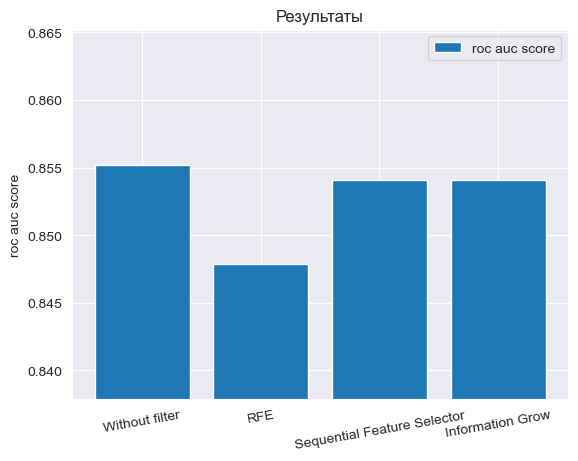

In [190]:
methods = [res[0] for res in results]
roc_scores = [res[2] for res in results]

plt.bar(methods, roc_scores, label='roc auc score')

plt.gca().set_ylabel('roc auc score')
plt.gca().set_title('Результаты')
plt.gca().legend()
plt.xticks(rotation=10)
plt.gca().set_ylim([min(roc_scores) - 0.01, max(roc_scores) + 0.01])

plt.show()

Найдем наиболее точный метод

In [191]:
best = max(results, key=lambda res: res[2])[0]
print("Наиболее подходящий метод:", best)

Наиболее подходящий метод: Without filter


In [192]:
sel_cols = next(x[1] for x in results if x[0] == best)
train = train.loc[:, np.append(sel_cols, res_col)]
test = test.loc[:, sel_cols]

all_cols = sel_cols

x = train[all_cols]
y = train[res_col]
sel_cols

['Age',
 'Driving_License',
 'Previously_Insured',
 'Region_Code',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Gender',
 'Vehicle_Age',
 'Vehicle_Damage']

### Сэмплирование

Посмотрим на исходные данные

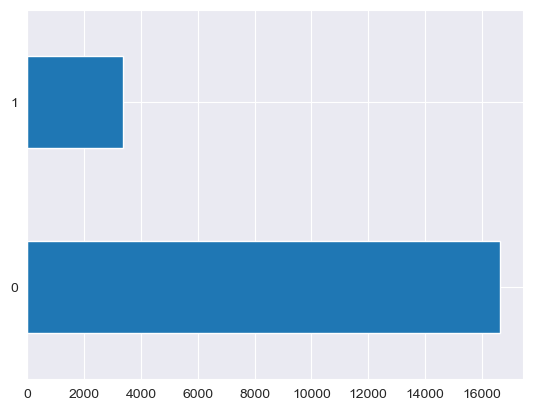

In [193]:
y.value_counts().plot(kind="barh")
plt.show()

In [194]:
results = []
def resample(sampler, sample):
    x_train, x_test, y_train, y_test = train_test_split(*sample, test_size=0.3,
                                                        random_state=7)
    return sampler, test_by_clf(GaussianNB(), x_train, y_train, x_test, y_test), sample

def get_probs_and_scores(predictor, x_train, y_train, x_test, y_test):
    train_pred_proba = predictor.predict_proba(x_train)
    test_pred_proba = predictor.predict_proba(x_test)
    return {
        "train_pred_proba": train_pred_proba[:, 1],
        "test_pred_proba": test_pred_proba[:, 1],
        "train_score": roc_auc_score(y_train, train_pred_proba[:, 1]),
        "test_score": roc_auc_score(y_test, test_pred_proba[:, 1])
    }

RandomOverSampler

In [195]:
ros = RandomOverSampler(random_state=0).fit_resample(x, y)
ros_name = "over sampling"
results.append(resample(ros_name, ros))

RandomUnderSampler

In [196]:
rus = RandomUnderSampler(random_state=0).fit_resample(x, y)
rus_name = "under sampling"
results.append(resample(rus_name, rus))

TomekLinks

In [197]:
# tl = TomekLinks().fit_resample(x, y)
# tl_name = "TomekLinks"
# results.append(resample(tl_name, tl))

NearMiss

In [198]:
nm = NearMiss().fit_resample(x, y)
nm_name = "NearMiss"
results.append(resample(nm_name, nm))

Smote

In [199]:
smote = SMOTE(random_state=0).fit_resample(x, y)
smote_name = "Smote"
results.append(resample(smote_name, smote))

Instance Hardness Threshold

In [200]:
# iht = InstanceHardnessThreshold(random_state=0).fit_resample(x, y)
# iht_name = "Instance Hardness Threshold"
# results.append(resample(iht_name, iht))

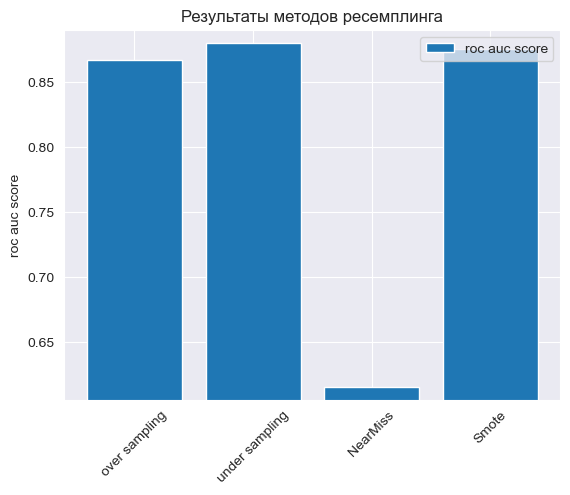

In [201]:
methods = [res[0] for res in results]
roc_scores = [res[1] for res in results]

plt.bar(methods, roc_scores, label='roc auc score')
plt.xticks(rotation=45)
plt.gca().set_ylabel('roc auc score')
plt.gca().set_title('Результаты методов ресемплинга')
plt.gca().legend()
plt.gca().set_ylim([min(roc_scores) - 0.01, max(roc_scores) + 0.01])

plt.show()

Получим лучший метод

In [202]:
best = max(results, key=lambda res: res[1])[0]
print("Наиболее подходящий метод:", best)

x, y = next(x[2] for x in results if x[0] == best)

Наиболее подходящий метод: under sampling


Посмотрим на значения теперь

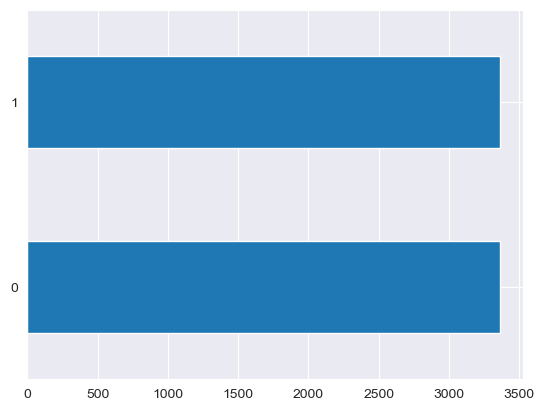

In [203]:
y.value_counts().plot(kind="barh")
plt.show()

In [204]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                    random_state=0)
all_data = (x_train, y_train, x_test, y_test)

Подберем классификаторы

In [222]:
all_clfs = []
all_clfs_names = []
all_scores = []

KNN

In [223]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors': range(15, 20),
          'weights': ['uniform', 'distance']}
grid = GridSearchCV(KNeighborsClassifier(), params, scoring='roc_auc')
grid.fit(x_train, y_train)

knn =  grid.best_estimator_
score = get_score(knn, x_test, y_test)

all_clfs.append(knn)
all_clfs_names.append("knn")
all_scores.append(score)


print(f'Лучшие параметры: {grid.best_params_}')
print(f'ROC-AUC: {score: .2f}')

Лучшие параметры: {'n_neighbors': 18, 'weights': 'uniform'}
ROC-AUC:  0.86


Логистическая регрессия

In [224]:
parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
              'penalty': (None, 'l1', 'l2', 'elasticnet')}

grid = GridSearchCV(LogisticRegression(), parameters, scoring='roc_auc')
grid.fit(x_train, y_train)

lr = grid.best_estimator_
score = get_score(lr, x_test, y_test)

all_clfs.append(lr)
all_clfs_names.append('Logistic Regression')
all_scores.append(score)

print(f'Лучшие параметры: {grid.best_params_}')
print(f'ROC-AUC: {score: .2f}')

Лучшие параметры: {'C': 1, 'penalty': 'l2'}
ROC-AUC:  0.85


Наивный байесовский классификатор

In [225]:
gauss_nb = cross_fit_clf(GaussianNB(), x_train, y_train)
score = get_score(gauss_nb, x_test, y_test)

all_clfs.append(gauss_nb)
all_clfs_names.append("gauss_nb")
all_scores.append(score)

print(f'ROC-AUC: {score:.2f}')

ROC-AUC: 0.86


Метод опорных векторов

In [226]:
svc = SVC(probability=True)
svc.fit(x_train, y_train)
score = get_score(svc, x_test, y_test)

all_clfs.append(svc)
all_clfs_names.append("svc")
all_scores.append(score)

print(f'ROC-AUC: {score: .2f}')

ROC-AUC:  0.87


Линейный дискриминантный анализ

In [227]:
lda = cross_fit_clf(LinearDiscriminantAnalysis(), x_train, y_train)
score = get_score(lda, x_test, y_test)

all_clfs.append(lda)
all_clfs_names.append("lda")
all_scores.append(score)

print(f'ROC-AUC: {score: .2f}')

ROC-AUC:  0.85


Квадратичный дискриминантный анализ

In [228]:
qda = cross_fit_clf(QuadraticDiscriminantAnalysis(), x_train, y_train)
score = get_score(qda, x_test, y_test)

all_clfs.append(qda)
all_clfs_names.append("qda")
all_scores.append(score)

print(f'ROC-AUC: {score: .2f}')

ROC-AUC:  0.88


Выведем графики Roc

In [230]:
def make_mult_roc_curve_plots(predictors, x_train, y_train, x_test, y_test):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 16))



    for ax, (clf_model, label) in zip(axs.flatten(), predictors):

        train_pred_proba = clf_model.predict_proba(x_train)[:, 1]
        test_pred_proba = clf_model.predict_proba(x_test)[:, 1]
        train_score = roc_auc_score(y_train, train_pred_proba)
        test_score = roc_auc_score(y_test, test_pred_proba)

        train_fpr, train_tpr, _ = roc_curve(y_train, train_pred_proba)
        test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_proba)

        ax.plot(train_fpr, train_tpr,
                label=f'Training ROC curve ('
                      f'AUC = {train_score:.2f})')
        ax.plot(test_fpr, test_tpr,
                    label=f'Test ROC curve ('
                          f'AUC = {test_score:.2f})')

        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([-0.05, 1.05])
        ax.set_ylim([-0.05, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{label}')
        ax.legend(loc="lower right")

    plt.show()

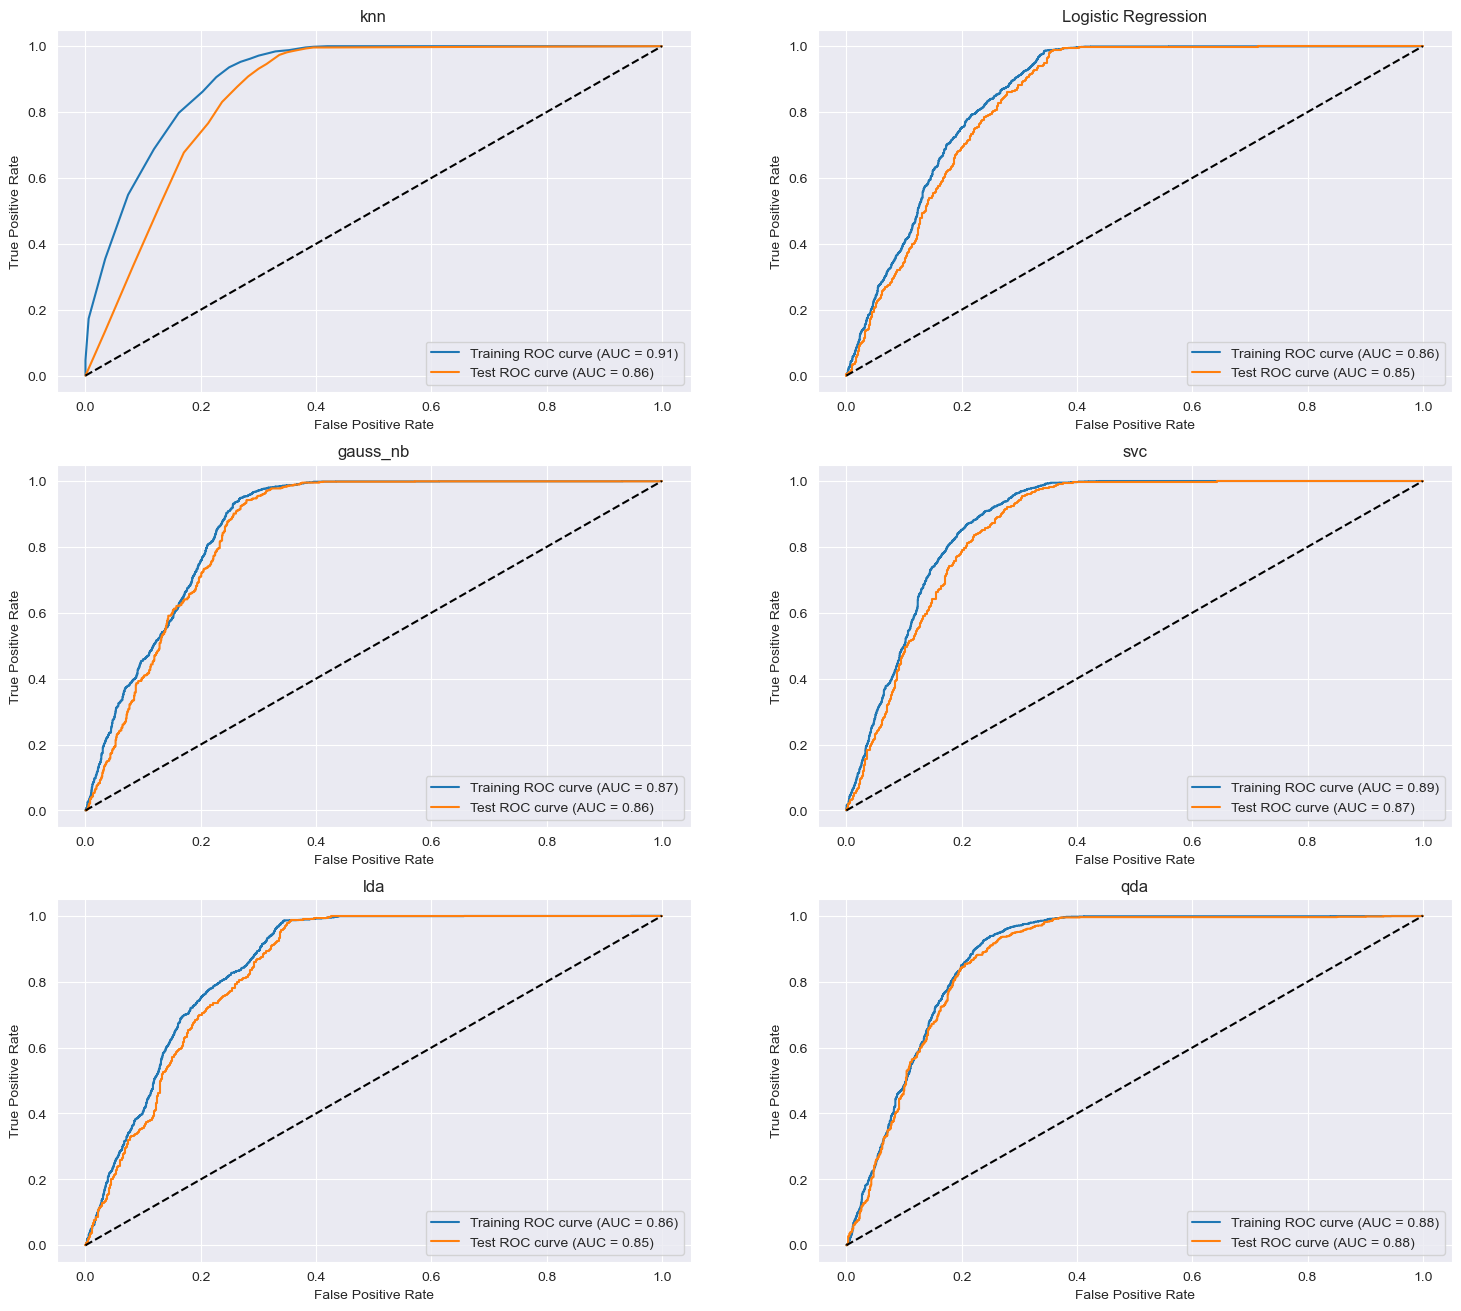

In [231]:
make_mult_roc_curve_plots(zip(all_clfs, all_clfs_names), *all_data)


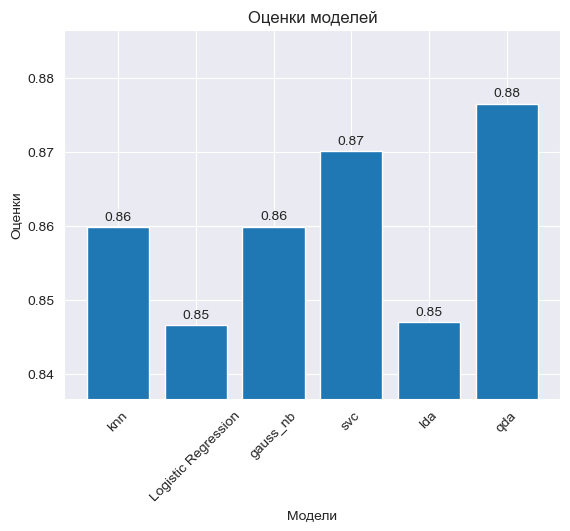

In [238]:
plt.bar(all_clfs_names, all_scores)
plt.xticks(rotation=45)

plt.gca().set_title('Оценки моделей')
plt.gca().set_xlabel('Модели')
plt.gca().set_ylabel('Оценки')

for i, score in enumerate(all_scores):
    plt.gca().text(i, score+0.001, f'{score:.2f}', horizontalalignment='center')
plt.gca().set_ylim([min(all_scores) - 0.01, max(all_scores) + 0.01])

plt.show()
